# Two State Systems

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Work in the basis of (non-degenerate) energy eigenstates then
$$
H = \begin{bmatrix}
E_1 & 0 \\
0 & E_2 \end{bmatrix}
$$
with
$$
E_2 > E_1 \; .
$$
Measure time $\tau$ in units of the period $T$ of beats between the energy eigenstates:
$$
\tau = t / T \quad, \quad T = \frac{h}{E_2 - E_1} \; .
$$
A normalized initial state,
$$
|\psi(0)\rangle = \begin{bmatrix}c_1 e^{i\theta_1} \\ c_2  e^{i\theta_2} \end{bmatrix} \quad, \quad
c_1^2 + c_2^2 = 1 \; ,
$$
evolves while not being measured as
$$
|\psi(t)\rangle = 
e^{i E_1 t/\hbar + i\theta_1}
\begin{bmatrix}
c_1 \\
c_2 e^{2\pi i \tau + i(\theta_2 - \theta_1)}\end{bmatrix} \; .
$$

Consider an arbitrary observable
$$
Q = \begin{bmatrix}
Q_{11} & Q_{12} e^{i\alpha} \\
Q_{12} e^{-i\alpha} & Q_{22}
\end{bmatrix}
$$
where $Q_{11}, Q_{12}, Q_{22}, \alpha$ are all real.  Assume that $Q$ is incompatible with $H$ so that
$$
[H,Q] = E_1 (r - 1) \begin{bmatrix}
0 & -Q_{12} e^{i\alpha} \\
Q_{12} e^{-i\alpha} & 0 \end{bmatrix}
\ne 0 \quad\Rightarrow\quad Q_{12} \ne 0 \; .
$$

The corresponding (non-degenerate) eigenvalues are:
$$
q_\pm = q_0 \pm \Delta q
$$
with
$$
q_0 = \frac{1}{2}\left( Q_{11} + Q_{22}\right) \quad, \quad
\Delta q^2 = \left(\frac{Q_{11} - Q_{22}}{2}\right)^2 + Q_{12}^2 \; .
$$
The corresponding normalized eigenvectors of $Q$ in the energy eigenbasis are:
$$
\left|\phi_\pm\right\rangle = \frac{1}{\sqrt{1 + p_\pm^2}} \begin{bmatrix}
e^{i\alpha} p_\pm \\ 1 \end{bmatrix}
$$
with
$$
p_\pm = \left( \sqrt{s^2 - 1} \pm s\right) \quad, \quad
s \equiv \frac{\Delta q}{Q_{12}} = \sqrt{1 + \left(\frac{Q_{11}-Q_{22}}{2 Q_{12}}\right)^2} \ge 1 \; .
$$
The probability of a measurement of $Q$ giving $q_\pm$ after time $t$ is
$$
\left|\langle \phi_\pm | \psi(t)\rangle\right|^2 =
\frac{1}{1+p_\pm^2} \left[
c_2^2 + c_1^2 p_\pm^2 + 2 c_1 c_2 p_\pm \cos\left( 2\pi \tau + \alpha + \theta_2 - \theta_1
\right)\right] \; ,
$$
with
$$
\left|\langle \phi_+ | \psi(t)\rangle\right|^2 + \left|\langle \phi_- | \psi(t)\rangle\right|^2
= c_1^2 + c_2^2 = 1 \; .
$$

Note that measurement probabilities for $Q$ are fully specified by $s$ and $\alpha$, and do not depend on $q_0$ or $\Delta q$. Instead, the four degrees of freedom (offset, amplitude, frequency and phase) of the oscillating $\left|\langle \phi_\pm | \psi(t)\rangle\right|^2$ are due to:
 - Two of the four degrees of freedom in the Hermitian matrix $Q$.
 - One degree of freedom from the state $|\Psi(t)\rangle$ when the measurement is performed.
 - One degree of freedom due to the beat frequency $(E_2 - E_1)/h$.
 
The extra two degrees of freedom in $Q$ determine how the eigenvalues are defined. In particular, two compatible observables $P$ and $Q$ that only differ in a linear transformation between their eigenvalues would have identical measurement probabilities.

Two different observables $A$ and $B$ that do not with $H$, specified by $s_A, s_B$ and $\alpha_A, \alpha_B$ do not commute with each other unless:
$$
s_A = s_B \quad \text{and} \quad \alpha_A - \alpha_B = n \pi
$$
for some integer $n$. If $n$ is even (odd), then $A$ and $B$ have the same (swapped) eigenstates.

In [2]:
def twostate(initial=[1,1], observables=[], measurements=[],
             ntrials=4, ncycle=10, nt=100, seed=123):
    """Simulate measurements of arbitrary observables in a two-state universe.
    
    The initial state does not need to be normalized.

    Observables are Q0,Q1,Q2,...,QN with [H,Q0] = 0 and [H,Qk] != 0 for k=1,2,...,N.
    Q1,...,QN are specified with an array of tuples (s,alpha) where:
     - s determines the amplitude of measurement probabilities.
     - alpha determines the phase of measurement probabilities.
    
    [Qj,Qk] = 0 only if s[j]=s[k] and alpha[j]-alpha[k] = n pi, with n integer.

    Measurements are specified as an array of tuples (t,k) where:
     - t specifies when the measurement is performed in units of T, and
     - k specifies which observable is measured.
    The measurement times must be increasing.
    """
    # Normalize and set the initial state.
    assert len(initial) == 2
    state0 = np.asarray(initial, dtype=complex)
    state0 /= np.sqrt(np.sum(np.absolute(initial) ** 2))
    # Initialize a time grid covering ncycle periods at the E2-E1 beat frequency
    # with nt samples per cycle.
    tgrid = np.linspace(0., ncycle, nt * ncycle + 1)
    # Initialize probabilties over the time grid.
    nobs = len(observables)
    prob = np.zeros((nobs + 1, len(tgrid)))
    # Calculate eigenstates for each observable.
    eigenstate = np.empty((nobs + 1, 2, 2), dtype=complex)
    eigenstate[0] = [[1., 0.], [0., 1.]]
    if nobs > 0:
        s, alpha = zip(*observables)
        s = np.array(s)
        alpha = np.array(alpha)
        p0 = np.sqrt(s ** 2 - 1)
        eigenstate[1:, :, 1] = 1.
        eigenstate[1:, 0, 0] = np.exp(1j * alpha) * (p0 + s)
        eigenstate[1:, 1, 0] = np.exp(1j * alpha) * (p0 - s)
    # Normalize.
    eigenstate /= np.sqrt(np.sum(np.absolute(eigenstate) ** 2, axis=-1)
                         ).reshape((nobs + 1, 2, 1))
    # Initialize labels.
    label = [chr(65 + i) for i in range(nobs + 1)]
    ymin = '$' + ','.join([f'{chr(97 + i)}_1' for i in range(nobs + 1)]) + '$'
    ymax = '$' + ','.join([f'{chr(97 + i)}_2' for i in range(nobs + 1)]) + '$'
    # Determine the measurement times.
    tmeasure = np.array([when for (when,what) in measurements])
    if len(tmeasure) > 0:
        assert np.all(np.diff(tmeasure) > 0) and tmeasure[-1] < tgrid[-1]
    # Initialize the simulation and plots.
    gen = np.random.RandomState(seed=seed)
    fig, ax = plt.subplots(ntrials, 1, sharex=True, figsize=(12, 3 * ntrials))
    # Loop over realizations.
    for k in range(ntrials):
        # Loop over measurements.
        tnow = 0.
        state = state0
        for j, tnext in enumerate(np.append(tmeasure, tgrid[-1])):
            sel = (tgrid >= tnow) & (tgrid <= tnext)
            dt = tgrid - tnow
            c1, c2 = np.absolute(state)
            theta1, theta2 = np.angle(state)
            # Calculate probabilities while system is unobserved during [tnow, tnext].
            prob[0, sel] = c1 ** 2
            for i in range(nobs):
                pp = p0[i] + s[i]
                phi = alpha[i] + theta2 - theta1
                prob[i + 1, sel] = (
                    c2 ** 2 + (c1 * pp) ** 2 +
                    2 * c1 * c2 * pp * np.cos(2 * np.pi * dt[sel] + phi)
                ) / (1 + pp ** 2)
            if j < len(measurements):
                # Perform a measurement.
                what = measurements[j][1]
                if gen.uniform() < prob[what, sel][-1]:
                    # Project to the measured state.
                    state = eigenstate[what][0]
                else:
                    state = eigenstate[what][1]
            tnow = tnext

        ls=['-', '--', ':']
        for i in range(nobs + 1):
            ax[k].plot(tgrid, prob[i], lw=2, ls=ls[i % len(ls)], label=label[i])
        ax[k].legend(ncol=nobs+1)
        ax[k].set_xlim(0, tgrid[-1])
        ax[k].set_ylim(-0.01, 1.01)
        ax[k].set_ylabel(f'Prob to measure {ymax}')
        rhs = ax[k].twinx()
        rhs.set_ylim(-0.02, 1.02)
        rhs.set_yticks([0,1])
        rhs.set_yticklabels([ymin, ymax])
        rhs.set_ylabel('Expectation value', labelpad=-20)
    ax[-1].set_xlabel('Elapsed time $t$ / $T$')
    plt.subplots_adjust(bottom=0.04, top=0.99, left=0.05, right=0.94, hspace=0.1)

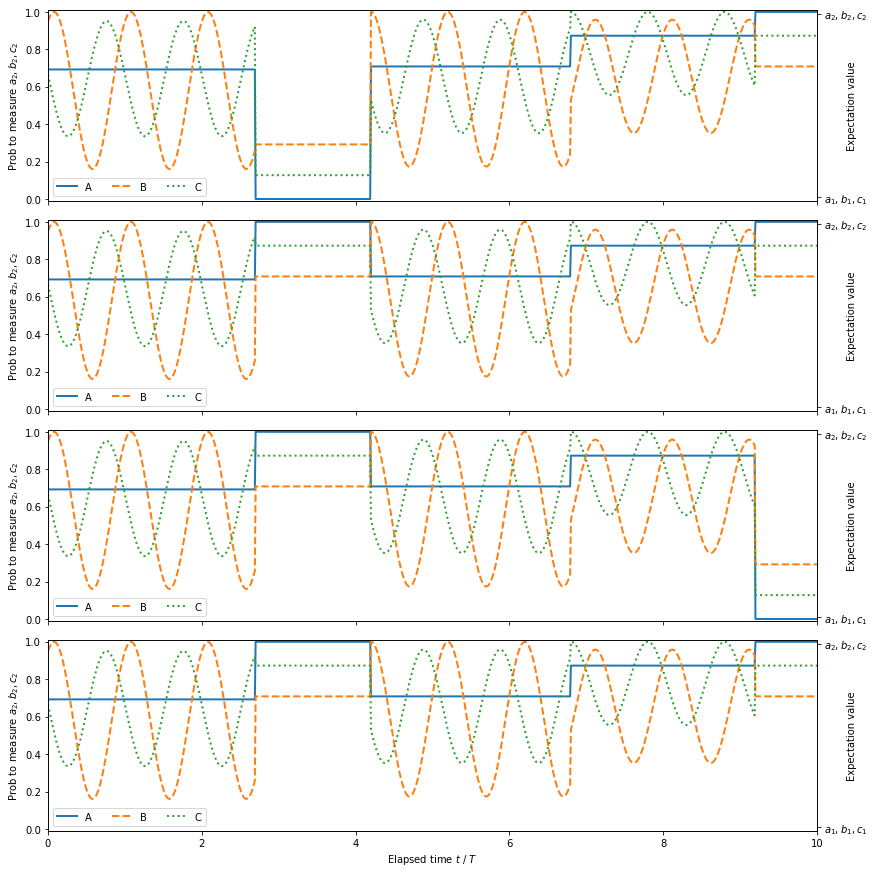

In [3]:
twostate(initial=[1.5, 1],
         observables=[(1.1, -0.5), (1.5, 1.5)],
         measurements=[(2.7, 0), (4.2, 1), (6.8, 2), (9.2, 0)],
         seed=10)
plt.savefig('twostate_evolution.pdf')